In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from torchvision.utils import make_grid
import joblib
import plotly.express as px
from sklearn.model_selection import train_test_split, learning_curve
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
# import umap
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
import lightgbm as lgb
import warnings
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

image_size = 256

In [34]:
# DCGAN Base
class base_Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=256, gf_dim=64):
        super(base_Generator, self).__init__()
        self.gf_dim = gf_dim
        self.z_dim = z_dim
        self.main = nn.Sequential(
            # input Z
            nn.ConvTranspose2d(z_dim, gf_dim * 16,kernel_size= 4,stride= 1,padding=0, bias=False),
            nn.BatchNorm2d(gf_dim * 16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(gf_dim * 16, gf_dim * 8,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim * 8),
            nn.ReLU(True),
            # state size: (gf_dim*8) x 8 x 8
            nn.ConvTranspose2d(gf_dim * 8, gf_dim * 4,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim * 4),
            nn.ReLU(True),
            # state size: (gf_dim*4) x 16 x 16
            nn.ConvTranspose2d(gf_dim * 4, gf_dim * 2,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim * 2),
            nn.ReLU(True),
            # state size: (gf_dim*2) x 32 x 32
            nn.ConvTranspose2d(gf_dim * 2, gf_dim,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim),
            nn.ReLU(True),
            # state size: (gf_dim) x 64 x 64
            nn.ConvTranspose2d(gf_dim, gf_dim // 2,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim // 2),
            nn.ReLU(True),
            # state size: (gf_dim//2) x 128 x 128
            nn.ConvTranspose2d(gf_dim // 2, 3,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.Tanh()
            # state size: (3) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)
    
class base_Discriminator(nn.Module):
    def __init__(self):
        super(base_Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1) 
        self.leaky1 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)  
        self.leaky2 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  
        self.leaky3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  
        self.leaky4 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) 
        self.leaky5 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv6 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  
        self.leaky6 = nn.LeakyReLU(0.2, inplace=True)
        
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=1, padding=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)  
        
        self.flatten = nn.Flatten()
        
        self.dense = nn.Linear((128 + 256 + 512) * 4 * 4, 1)

    def forward(self, x):
        x = self.leaky1(self.conv1(x))  # 128x128x16
        x = self.leaky2(self.conv2(x))  # 64x64x32
        x = self.leaky3(self.conv3(x))  # 32x32x64
        x = self.leaky4(self.conv4(x))  # 16x16x128
        pool1 = self.pool1(x)           # 4x4x128
        
        x = self.leaky5(self.conv5(x))  # 8x8x256
        pool2 = self.pool2(x)           # 2x2x256
        
        x = self.leaky6(self.conv6(x))  # 4x4x512
        
        pool1 = F.interpolate(pool1, size=(4, 4), mode='bilinear', align_corners=False)  
        pool2 = F.interpolate(pool2, size=(4, 4), mode='bilinear', align_corners=False)
        
        concat = torch.cat([pool1, pool2, x], dim=1)
        
        flattened = self.flatten(concat)
        output = self.dense(flattened)
        
        return torch.sigmoid(output), concat

In [35]:
class optim_Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=256, gf_dim=64):
        super(optim_Generator, self).__init__()
        self.gf_dim = gf_dim
        self.z_dim = z_dim
        self.main = nn.Sequential(
            # input Z
            nn.ConvTranspose2d(z_dim, 1024,kernel_size= 4,stride= 1,padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # 1024 x 4 x 4
            nn.ConvTranspose2d(1024, 512,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 8 x 8
            nn.ConvTranspose2d(512, 256,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 16 x 16
            nn.ConvTranspose2d(256, 128,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 32 x 32
            nn.ConvTranspose2d(128, 64,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 64 x 64
            nn.ConvTranspose2d(64, 32,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32 x 128 x 128
            nn.ConvTranspose2d(32, 3,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.Tanh()
            # 3 x 256 x 256
        )

    def forward(self, input):
        return self.main(input)
    
    
class optim_Discriminator(nn.Module):
    def __init__(self):
        super(optim_Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1) 
        # self.bn1 = nn.BatchNorm2d(16)
        self.leaky1 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)  
        # self.bn2 = nn.BatchNorm2d(32)
        self.leaky2 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  
        # self.bn3 = nn.BatchNorm2d(64)
        self.leaky3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  
        # self.bn4 = nn.BatchNorm2d(128)
        self.leaky4 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) 
        # self.bn5 = nn.BatchNorm2d(256)
        self.leaky5 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv6 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  
        # self.bn6 = nn.BatchNorm2d(512)
        self.leaky6 = nn.LeakyReLU(0.2, inplace=True)
        
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=1, padding=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)  
        
        self.flatten = nn.Flatten()
        
        self.dense = nn.Linear((128 + 256 + 512) * 4 * 4, 1)

    def forward(self, x):
        x = self.leaky1(self.conv1(x))  
        x = self.leaky2(self.conv2(x))
        x = self.leaky3(self.conv3(x))
        x = self.leaky4(self.conv4(x))
        
        pool1 = self.pool1(x)  
        
        x = self.leaky5(self.conv5(x))
        
        pool2 = self.pool2(x)  
        
        x = self.leaky6(self.conv6(x))
        
        pool1 = F.interpolate(pool1, size=(4, 4), mode='bilinear', align_corners=False)  
        pool2 = F.interpolate(pool2, size=(4, 4), mode='bilinear', align_corners=False)
        
        concat = torch.cat([pool1, pool2, x], dim=1)
        
        flattened = self.flatten(concat)
        output = self.dense(flattened)
        
        return torch.sigmoid(output), concat

In [36]:
class act_Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=256, gf_dim=64):
        super(act_Generator, self).__init__()
        self.gf_dim = gf_dim
        self.z_dim = z_dim
        self.main = nn.Sequential(
            # input Z
            nn.ConvTranspose2d(z_dim, 1024,kernel_size= 4,stride= 1,padding=0, bias=False),
            nn.BatchNorm2d(gf_dim * 16),
            nn.GELU(),
            
            nn.ConvTranspose2d(1024, 512,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(512),
            nn.GELU(),
            # state size: (gf_dim*8) x 8 x 8
            nn.ConvTranspose2d(512, 256,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim * 4),
            nn.GELU(),
            # state size: (gf_dim*4) x 16 x 16
            nn.ConvTranspose2d(256, 128,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim * 2),
            nn.GELU(),
            # state size: (gf_dim*2) x 32 x 32
            nn.ConvTranspose2d(128, 64,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim),
            nn.GELU(),
            # state size: (gf_dim) x 64 x 64
            nn.ConvTranspose2d(64, 32,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(gf_dim // 2),
            nn.GELU(),
            # state size: (gf_dim//2) x 128 x 128
            nn.ConvTranspose2d(32, 3,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.Tanh()
            # state size: (3) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)
    
class act_Discriminator(nn.Module):
    def __init__(self):
        super(act_Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1) 
        self.leaky1 = nn.ELU(0.2, inplace=True)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)  
        self.leaky2 = nn.ELU(0.2, inplace=True)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  
        self.leaky3 = nn.ELU(0.2, inplace=True)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  
        self.leaky4 = nn.ELU(0.2, inplace=True)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) 
        self.leaky5 = nn.ELU(0.2, inplace=True)
        
        self.conv6 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  
        self.leaky6 = nn.ELU(0.2, inplace=True)
        
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=1, padding=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)  
        
        self.flatten = nn.Flatten()
        
        self.dense = nn.Linear((128 + 256 + 512) * 4 * 4, 1)

    def forward(self, x):
        x = self.leaky1(self.conv1(x))  # 128x128x16
        x = self.leaky2(self.conv2(x))  # 64x64x32
        x = self.leaky3(self.conv3(x))  # 32x32x64
        x = self.leaky4(self.conv4(x))  # 16x16x128
        pool1 = self.pool1(x)  # 4x4x128
        
        x = self.leaky5(self.conv5(x))  # 8x8x256
        pool2 = self.pool2(x)  # 2x2x256
        
        x = self.leaky6(self.conv6(x))  # 4x4x512
        
        pool1 = F.interpolate(pool1, size=(4, 4), mode='bilinear', align_corners=False)  
        pool2 = F.interpolate(pool2, size=(4, 4), mode='bilinear', align_corners=False)
        
        concat = torch.cat([pool1, pool2, x], dim=1)
        
        flattened = self.flatten(concat)
        output = self.dense(flattened)
        return torch.sigmoid(output), concat

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Generator class with layer visualization
class base_Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=256, gf_dim=64):
        super(base_Generator, self).__init__()
        self.gf_dim = gf_dim
        self.z_dim = z_dim
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, gf_dim * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(gf_dim * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf_dim * 16, gf_dim * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf_dim * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf_dim * 8, gf_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf_dim * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf_dim * 4, gf_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf_dim * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf_dim * 2, gf_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf_dim, gf_dim // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf_dim // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf_dim // 2, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        outputs = []
        for layer in self.main:
            input = layer(input)
            if isinstance(layer, nn.ConvTranspose2d):
                outputs.append(input)
        return input, outputs


# Discriminator class with layer visualization
class base_Discriminator(nn.Module):
    def __init__(self):
        super(base_Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self.leaky2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.leaky3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.leaky4 = nn.LeakyReLU(0.2, inplace=True)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.leaky5 = nn.LeakyReLU(0.2, inplace=True)

        self.conv6 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.leaky6 = nn.LeakyReLU(0.2, inplace=True)

        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)

        self.flatten = nn.Flatten()
        self.dense = nn.Linear((128 + 256 + 512) * 4 * 4, 1)

    def forward(self, x):
        outputs = []

        x = self.leaky1(self.conv1(x))  # 128x128x16
        outputs.append(x)
        x = self.leaky2(self.conv2(x))  # 64x64x32
        outputs.append(x)
        x = self.leaky3(self.conv3(x))  # 32x32x64
        outputs.append(x)
        x = self.leaky4(self.conv4(x))  # 16x16x128
        outputs.append(x)
        pool1 = self.pool1(x)           # 4x4x128

        x = self.leaky5(self.conv5(x))  # 8x8x256
        outputs.append(x)
        pool2 = self.pool2(x)           # 2x2x256

        x = self.leaky6(self.conv6(x))  # 4x4x512
        outputs.append(x)

        pool1 = F.interpolate(pool1, size=(4, 4), mode='bilinear', align_corners=False)
        pool2 = F.interpolate(pool2, size=(4, 4), mode='bilinear', align_corners=False)

        concat = torch.cat([pool1, pool2, x], dim=1)

        flattened = self.flatten(concat)
        output = self.dense(flattened)

        return torch.sigmoid(output), outputs


In [37]:
z_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

In [38]:
base_gen = base_Generator().to(device)
base_disc = base_Discriminator().to(device)

optim_gen = optim_Generator().to(device)
optim_disc = optim_Discriminator().to(device)

act_gen = act_Generator().to(device)
act_disc = act_Discriminator().to(device)

In [39]:
def load_gan_checkpoint(generator, discriminator, features_file, labels_file, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=True)

    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']

    features = np.load(features_file)
    labels = np.load(labels_file)

    return generator, discriminator, g_losses, d_losses, features, labels

In [40]:
base_gen, base_disc, base_g_losses, base_d_losses, base_features, base_labels = load_gan_checkpoint(
    base_gen, base_disc,
    features_file='/kaggle/input/base_dcgan_i_guess/pytorch/default/2/base_extracted_features.npy',
    labels_file='/kaggle/input/base_dcgan_i_guess/pytorch/default/2/base_extracted_labels.npy',
    checkpoint_path='/kaggle/input/base_dcgan_i_guess/pytorch/default/2/checkpoint.pth'
)

optim_gen, optim_disc, optim_g_losses, optim_d_losses, optim_features, optim_labels = load_gan_checkpoint(
    optim_gen, optim_disc,
    features_file='/kaggle/input/rmsprop_dcgan/pytorch/default/5/optim_extracted_features.npy',
    labels_file='/kaggle/input/rmsprop_dcgan/pytorch/default/5/optim_extracted_labels.npy',
    checkpoint_path='/kaggle/input/rmsprop_dcgan/pytorch/default/5/checkpoint.pth'
)

act_gen, act_disc, act_g_losses, act_d_losses, act_features, act_labels = load_gan_checkpoint(
    act_gen, act_disc,
    features_file='/kaggle/input/256x256_elu_gelu/pytorch/default/2/act_extracted_features.npy',
    labels_file='/kaggle/input/256x256_elu_gelu/pytorch/default/2/act_extracted_labels.npy',
    checkpoint_path='/kaggle/input/256x256_elu_gelu/pytorch/default/2/main_checkpoint.pth'
)

In [18]:
def plot_conv_layers(layers, n_cols=6):
    n_rows = (len(layers) + n_cols - 1) // n_cols  # Calculate required rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    # Handle the case where axes may be 1D
    if n_rows == 1:
        axes = [axes]
    
    for i, layer in enumerate(layers):
        # Take the first channel from the batch (index 0) and the first filter (index 0)
        layer = layer[0, 0].detach().cpu().numpy()

        row = i // n_cols
        col = i % n_cols
        ax = axes[row][col] if n_rows > 1 else axes[col]

        ax.imshow(layer, cmap='gray')
        ax.set_title(f'Layer {i+1}')
        ax.axis('off')

    # Hide remaining subplots if any
    for j in range(i + 1, n_rows * n_cols):
        row = j // n_cols
        col = j % n_cols
        ax = axes[row][col] if n_rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    
def plot_input_noise(noise):
    # Reshape noise to make it more suitable for visualization
    noise_reshaped = noise.view(noise.size(0), -1)  # Flatten the noise
    noise_reshaped = noise_reshaped.detach().cpu().numpy()

    plt.figure(figsize=(5, 5))
    plt.imshow(noise_reshaped, cmap='gray')
    plt.title('Input Noise')
    plt.colorbar()
    plt.show()
def plot_discriminator_layers(discriminator, x, n_cols=6):
    layer_outputs = []
    
    # Manually pass the input through each convolutional block in the discriminator
    x = discriminator.leaky1(discriminator.conv1(x))
    layer_outputs.append(x)  # After Conv1
    x = discriminator.leaky2(discriminator.conv2(x))
    layer_outputs.append(x)  # After Conv2
    x = discriminator.leaky3(discriminator.conv3(x))
    layer_outputs.append(x)  # After Conv3
    x = discriminator.leaky4(discriminator.conv4(x))
    layer_outputs.append(x)  # After Conv4
    pool1 = discriminator.pool1(x)
    layer_outputs.append(pool1)  # After Pool1
    
    x = discriminator.leaky5(discriminator.conv5(x))
    layer_outputs.append(x)  # After Conv5
    pool2 = discriminator.pool2(x)
    layer_outputs.append(pool2)  # After Pool2
    
    x = discriminator.leaky6(discriminator.conv6(x))
    layer_outputs.append(x)  # After Conv6
    
    # Call the same plot function for the layers
    plot_conv_layers(layer_outputs, n_cols=n_cols)

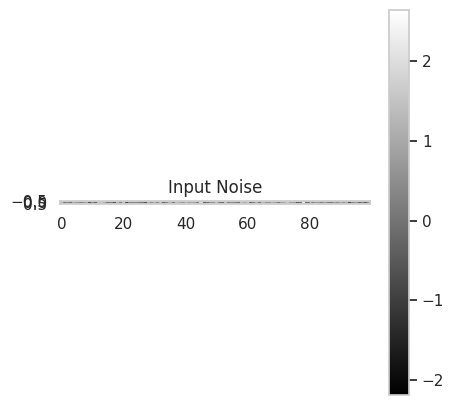

In [13]:
z = torch.randn(1, 100, 1, 1).cuda() 
plot_input_noise(z)

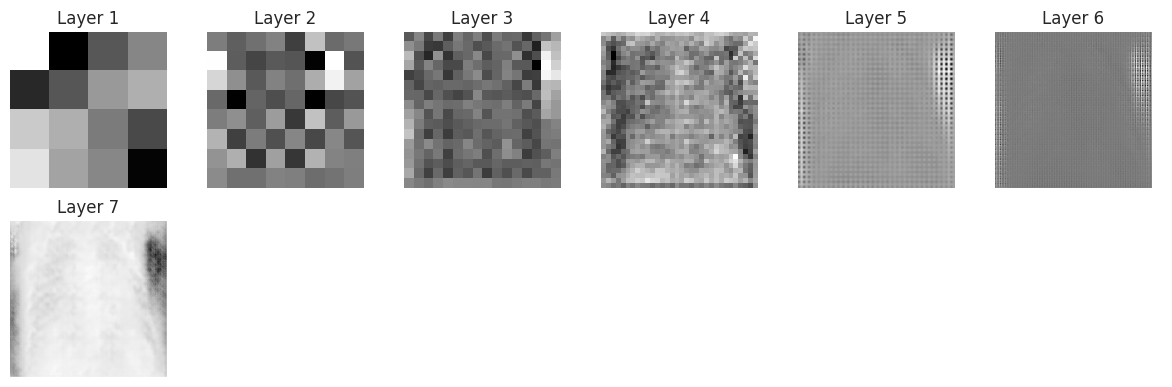

In [26]:
output, gen_layers = base_gen(z)
plot_conv_layers(gen_layers)

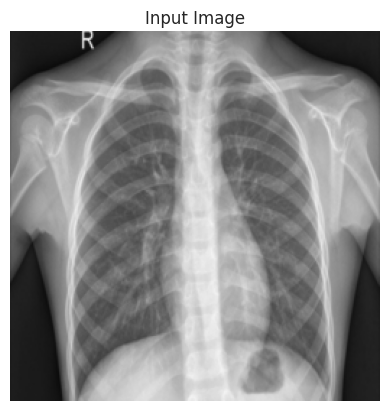

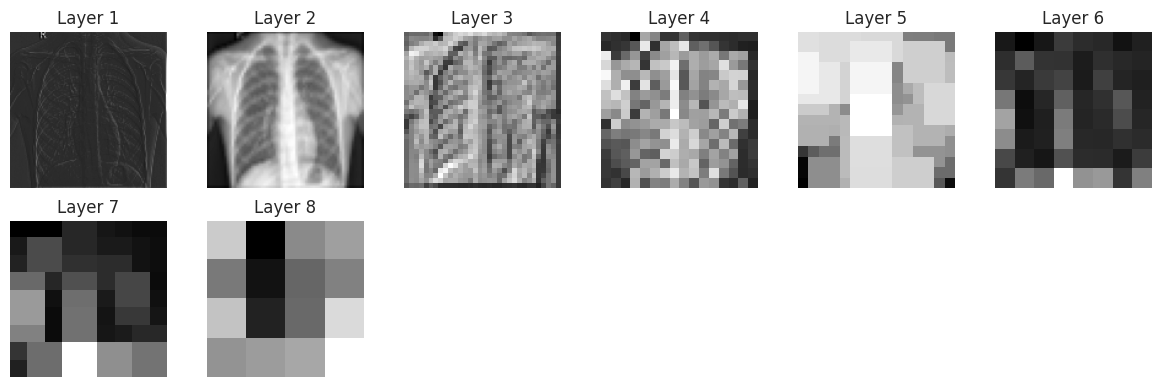

In [28]:
image_path = '/kaggle/input/test-dataset-for-gan-major-project/NORMAL/IM-0001-0001.jpeg'
img = Image.open(image_path).convert('RGB')  # Ensure it's RGB

# Preprocess the image: resize and convert to tensor
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
])

input_image = preprocess(img).unsqueeze(0).cuda()  

def plot_input_image(input_image):
    plt.imshow(transforms.ToPILImage()(input_image.squeeze(0).cpu()))  # Convert tensor to image
    plt.title('Input Image')
    plt.axis('off')
    plt.show()
plot_input_image(input_image)
plot_discriminator_layers(base_disc, input_image)

In [9]:
def show_tensor_images(image_tensor, num_images=9, size=(3, image_size, image_size), nrow=3, ax=None, title=""):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, normalize=True)
    if ax is None:
        plt.figure(figsize=(8, 8))
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.axis('off')
        plt.title(title,fontsize=20)
    else:
        ax.imshow(image_grid.permute(1, 2, 0).squeeze())
        ax.axis('off')
        ax.set_title(title,fontsize=20)

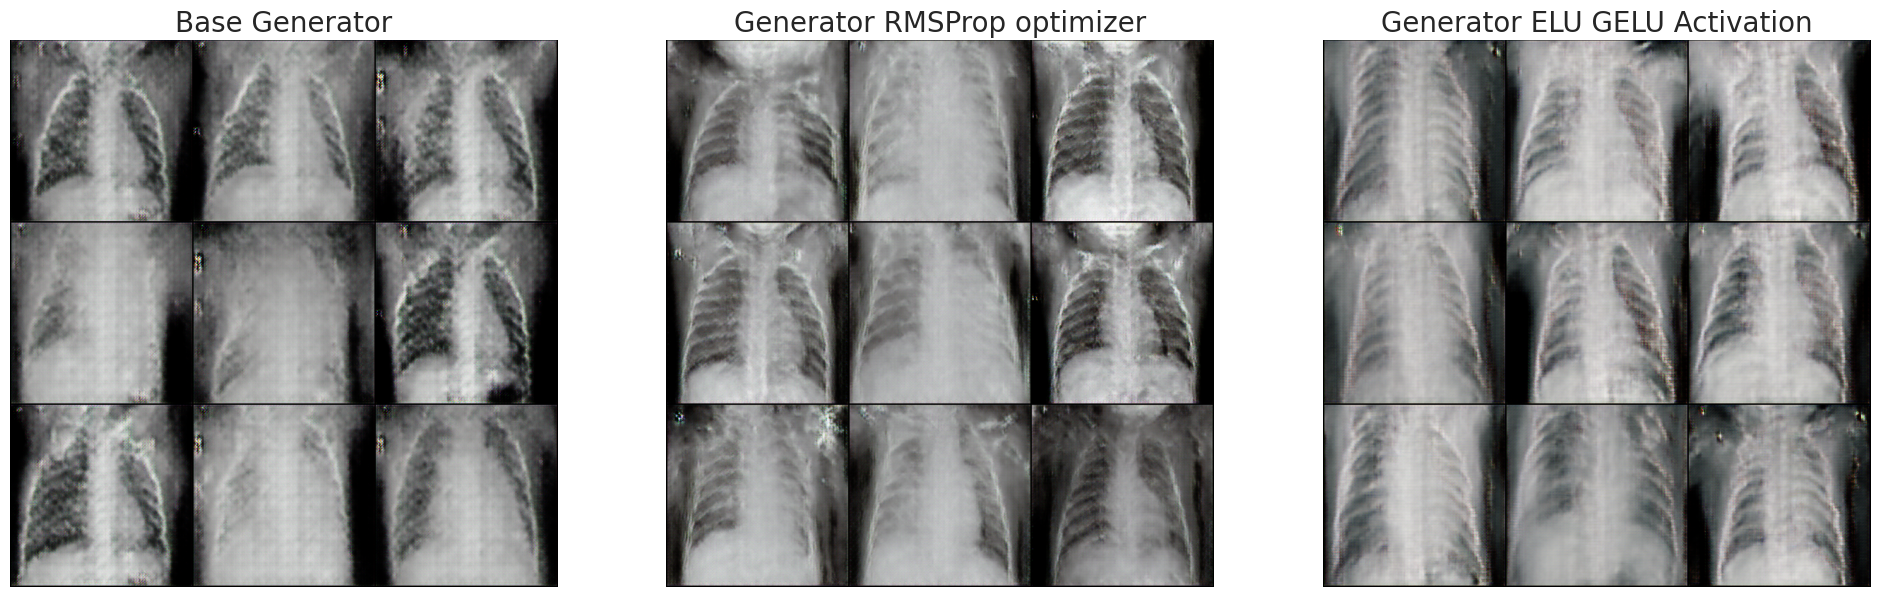

In [11]:
base_fake_images = base_gen(fixed_noise)
optim_fake_images = optim_gen(fixed_noise)
act_fake_images = act_gen(fixed_noise)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))

show_tensor_images(base_fake_images, ax=axs[0], title="Base Generator")
show_tensor_images(optim_fake_images, ax=axs[1], title="Generator RMSProp optimizer")
show_tensor_images(act_fake_images, ax=axs[2], title="Generator ELU GELU Activation")
plt.savefig("dcgan_generator_images.png", dpi=300, bbox_inches='tight')  
plt.show()

In [24]:
def plot_losses(ax, g_losses, d_losses, title="", legend_title="", step_bins=20):
    num_examples = (len(g_losses) // step_bins) * step_bins
    
    ax.plot(
        range(num_examples // step_bins),
        torch.Tensor(g_losses[:num_examples]).view(-1, step_bins).mean(1),
        label=legend_title + " Generator Loss",
        linewidth=2,   
        markersize=6   
    )

    ax.plot(
        range(num_examples // step_bins),
        torch.Tensor(d_losses[:num_examples]).view(-1, step_bins).mean(1),
        label=legend_title + " Discriminator Loss",
        linewidth=2,   
        markersize=6   
    )
    
    ax.set_xlabel("Training Steps", fontsize=14)        
    ax.set_ylabel("Loss", fontsize=14)                  
    ax.set_title(title, fontsize=16, fontweight='bold')  
    ax.legend(loc='upper right', fontsize=12)          
    ax.grid(True, linestyle='--', alpha=0.7)            
    ax.tick_params(axis='both', labelsize=12)

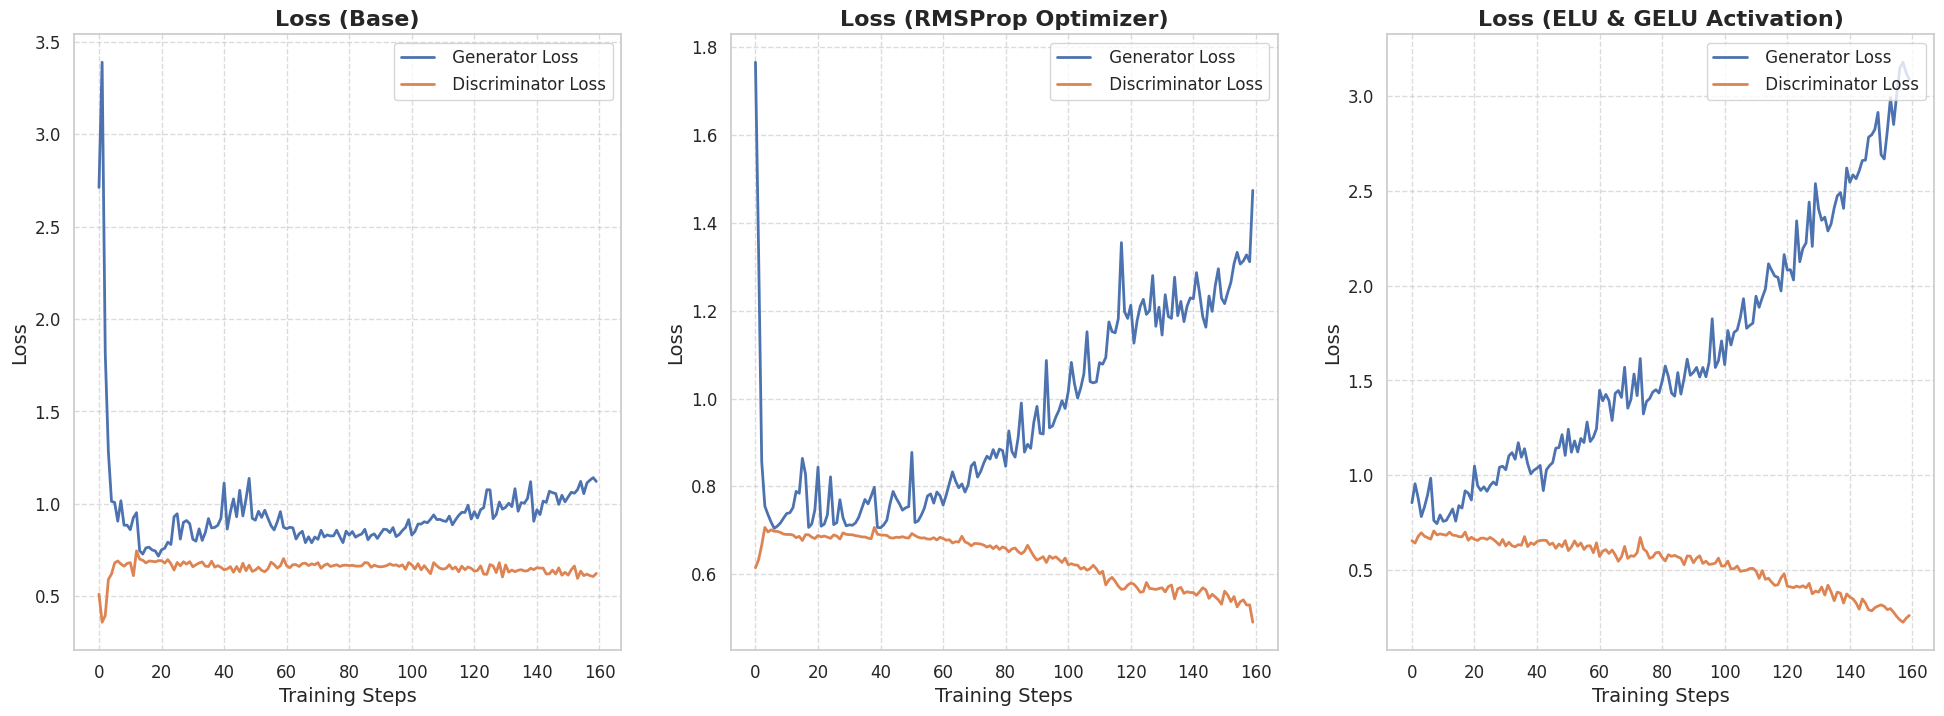

In [23]:
step_bins = 20
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

plot_losses(axs[0], base_g_losses, base_d_losses, "Loss (Base)")
plot_losses(axs[1], optim_g_losses, optim_d_losses, "Loss (RMSProp Optimizer)")
plot_losses(axs[2], act_g_losses, act_d_losses, "Loss (ELU & GELU Activation)")
plt.show()

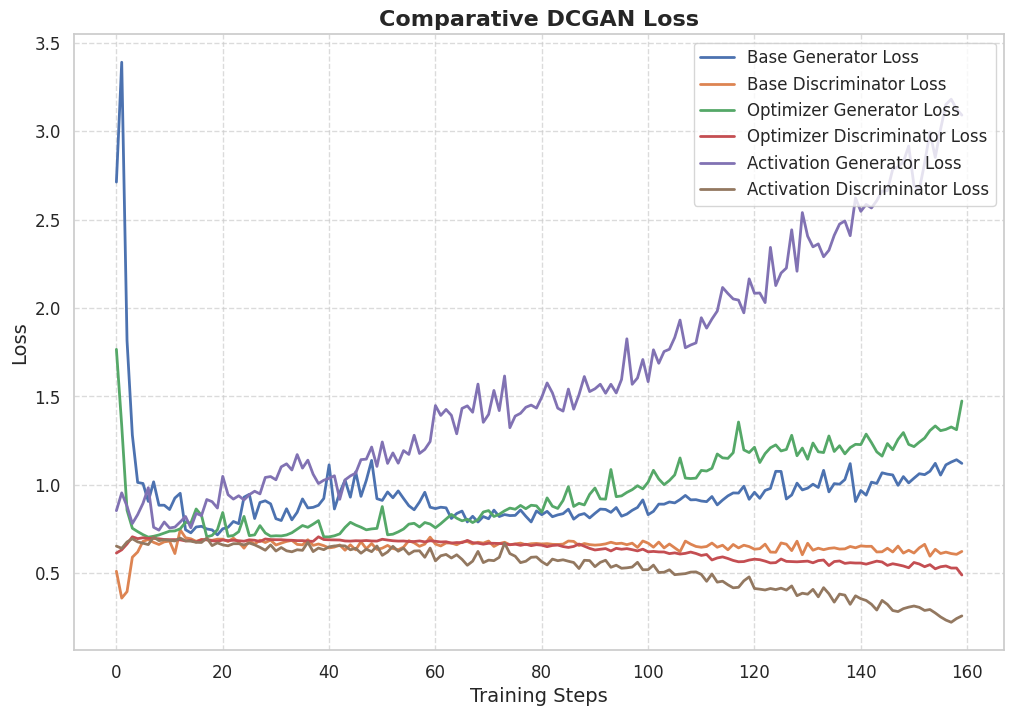

In [26]:
step_bins = 20
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

plot_losses(axs, base_g_losses, base_d_losses, legend_title='Base')
plot_losses(axs, optim_g_losses, optim_d_losses, legend_title='Optimizer')
plot_losses(axs, act_g_losses, act_d_losses, "Comparative DCGAN Loss", legend_title='Activation')
plt.savefig("combined_dcgan_loss.png", dpi=300, bbox_inches='tight')  
plt.show()

In [41]:
def evaluate_model(model, X_test, y_test, model_type='xgb'):
    if model_type == 'xgb':
        dtest = xgb.DMatrix(data=X_test, label=y_test)
        y_pred_prob = model.predict(dtest)
    elif model_type == 'lgb' or model_type=='clf':
        y_pred_prob = model.predict(X_test)
    else:
        raise ValueError("Unsupported model type. Use 'xgb' or 'lgb' or 'clf'.")

    y_pred = np.where(y_pred_prob > 0.5, 1, 0)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "pred":y_pred
    }

    return metrics

In [ ]:
import cupy as cp
from sklearn.model_selection import RandomizedSearchCV
X = cp.array(base_features)  
y = cp.array(base_labels)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
svm = SVC()
param_distributions = {
    'C': np.logspace(-3, 3, 10),  # C in range 0.001 to 1000
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 10)),
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [2, 3, 4],  # For poly kernel
    'class_weight': [None, 'balanced']
}
random_search = RandomizedSearchCV(svm, param_distributions, n_iter=50, cv=3, scoring='accuracy', random_state=42, verbose=1, n_jobs=-1)
random_search.fit(X_train.get(), y_train.get())
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Accuracy: {random_search.best_score_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [12]:
predictions = svm.predict(X_test.get())  

accuracy = accuracy_score(y_test.get(), predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


In [42]:
X_train,X_test,y_train,y_test = train_test_split(base_features,base_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

base_xgb_model = xgb.Booster()
base_xgb_model.load_model('/kaggle/input/base_dcgan_i_guess/pytorch/default/2/xgb_model.json')
base_xgb_metrics = evaluate_model(base_xgb_model, X_test, y_test, model_type='xgb')


base_lgb_model = lgb.Booster(model_file='/kaggle/input/base_dcgan_i_guess/pytorch/default/2/lgb_model.txt')
base_lgb_metrics = evaluate_model(base_lgb_model, X_test, y_test, model_type='lgb')

base_sclf = joblib.load('/kaggle/input/base_dcgan_i_guess/pytorch/default/2/stacking_classifier.pkl')
base_sclf_metrics = evaluate_model(base_sclf, X_test, y_test, model_type='clf')

In [43]:
optim_features = optim_features.reshape(optim_features.shape[0],-1)

In [44]:
X_train,X_test,y_train,y_test = train_test_split(optim_features,optim_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

optim_xgb_model = xgb.Booster()
optim_xgb_model.load_model('/kaggle/input/rmsprop_dcgan/pytorch/default/5/xgb_model.json')
optim_xgb_metrics = evaluate_model(optim_xgb_model, X_test, y_test, model_type='xgb')


optim_lgb_model = lgb.Booster(model_file='/kaggle/input/rmsprop_dcgan/pytorch/default/5/lgb_model.txt')
optim_lgb_metrics = evaluate_model(optim_lgb_model, X_test, y_test, model_type='lgb')

optim_sclf = joblib.load('/kaggle/input/rmsprop_dcgan/pytorch/default/5/stacking_classifier.pkl')
optim_sclf_metrics = evaluate_model(optim_sclf, X_test, y_test, model_type='clf')

In [45]:
X_train,X_test,y_train,y_test = train_test_split(act_features,act_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

act_xgb_model = xgb.Booster()
act_xgb_model.load_model('/kaggle/input/256x256_elu_gelu/pytorch/default/2/xgb_model.json')
act_xgb_metrics = evaluate_model(act_xgb_model, X_test, y_test, model_type='xgb')

act_lgb_model = lgb.Booster(model_file='/kaggle/input/256x256_elu_gelu/pytorch/default/2/lgb_model.txt')
act_lgb_metrics = evaluate_model(act_lgb_model, X_test, y_test, model_type='lgb')

act_sclf = joblib.load('/kaggle/input/256x256_elu_gelu/pytorch/default/2/stacking_classifier.pkl')
act_sclf_metrics = evaluate_model(act_sclf, X_test, y_test, model_type='clf')

In [46]:
def highlight_best_average(df):
    avg_acc = df.groupby('Feature Set')['Accuracy (%)'].mean()
    max_feature_set = avg_acc.idxmax()

    def highlight_feature_set(row):
        return ['background-color: darkgreen' if row.name[0] == max_feature_set else '' for _ in row]
    
    return df.style.apply(highlight_feature_set, axis=1)

# Create a metrics DataFrame
def create_metrics_dataframe(metrics_dicts, model_names, feature_sets):
    results = []
    for metrics, model_name, feature_set in zip(metrics_dicts, model_names, feature_sets):
        result = {
            "Model": model_name,
            "Precision": metrics['Precision'],
            "Recall": metrics['Recall'],
            "F1 Score": metrics['F1 Score'],
            "Accuracy (%)": metrics['Accuracy'] * 100,
        }
        results.append(result)

    df = pd.DataFrame(results)

    df['Feature Set'] = feature_sets
    df.set_index(['Feature Set', 'Model'], inplace=True)

    metrics_df = highlight_best_average(df).format({
        "Accuracy (%)": "{:.2f}",
        "Precision": "{:.2f}",
        "Recall": "{:.2f}",
        "F1 Score": "{:.2f}"
    }).set_table_styles(
        [{
            'selector': 'thead th',
            'props': [('background-color', '#40466e'), 
                      ('color', 'white'),
                      ('font-weight', 'bold'),
                      ('font-size', '18px')]
        },{
            'selector': 'tbody td',
            'props': [('padding', '10px'),
                      ('font-size', '15px')]
        }]
    ).set_properties(
        **{'width': '200px', 'border': '1px solid #b9b9b9'}  
    )
    
    return metrics_df

In [47]:
metrics_dicts = [
    base_xgb_metrics, base_lgb_metrics, base_sclf_metrics,
    optim_xgb_metrics, optim_lgb_metrics, optim_sclf_metrics,
    act_xgb_metrics, act_lgb_metrics, act_sclf_metrics,
]

model_names = [
    "XGBoost", "LightGBM", "Stacking Classifier",
    "XGBoost", "LightGBM", "Stacking Classifier",
    "XGBoost", "LightGBM", "Stacking Classifier",
]

feature_sets = [
    "Base", "Base", "Base",
    "Optimized", "Optimized", "Optimized",
    "Activation", "Activation", "Activation",
]
df_results = create_metrics_dataframe(metrics_dicts, model_names, feature_sets)
df_results

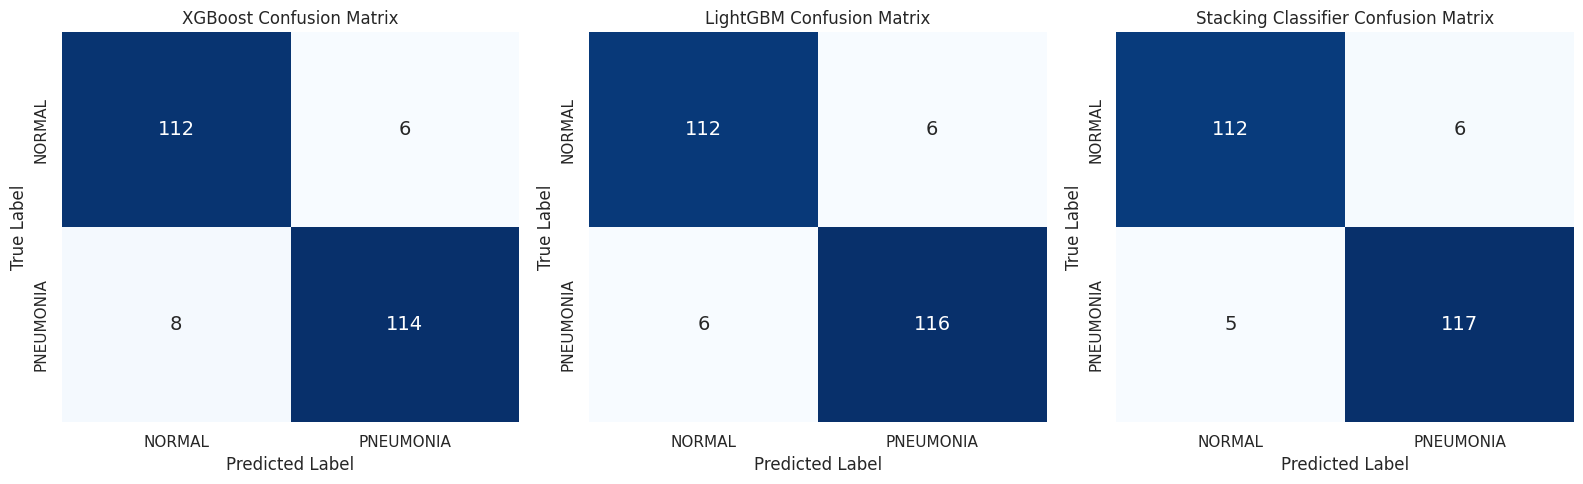

In [36]:
X_train,X_test,y_train,y_test = train_test_split(optim_features,optim_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

optim_xgb_model = xgb.Booster()
optim_xgb_model.load_model('/kaggle/input/rmsprop_dcgan/pytorch/default/5/xgb_model.json')
optim_xgb_metrics = evaluate_model(optim_xgb_model, X_test, y_test, model_type='xgb')

optim_lgb_model = lgb.Booster(model_file='/kaggle/input/rmsprop_dcgan/pytorch/default/5/lgb_model.txt')
optim_lgb_metrics = evaluate_model(optim_lgb_model, X_test, y_test, model_type='lgb')

optim_sclf = joblib.load('/kaggle/input/rmsprop_dcgan/pytorch/default/5/stacking_classifier.pkl')
optim_sclf_metrics = evaluate_model(optim_sclf, X_test, y_test, model_type='clf')

labels = ["NORMAL", "PNEUMONIA"]

xgb_conf_matrix = confusion_matrix(y_test, optim_xgb_metrics['pred'])
lgb_conf_matrix = confusion_matrix(y_test, optim_lgb_metrics['pred'])
sclf_conf_matrix = confusion_matrix(y_test, optim_sclf_metrics['pred'])

def beautify_confusion_matrix(ax, matrix, model_name, labels):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=labels, yticklabels=labels, annot_kws={"size": 14}, ax=ax)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

beautify_confusion_matrix(axes[0], xgb_conf_matrix, "XGBoost", labels)
beautify_confusion_matrix(axes[1], lgb_conf_matrix, "LightGBM", labels)
beautify_confusion_matrix(axes[2], sclf_conf_matrix, "Stacking Classifier", labels)
plt.tight_layout()
plt.savefig("combined_dcgan_classifier_conf_mat.png", dpi=300, bbox_inches='tight')  
plt.show()

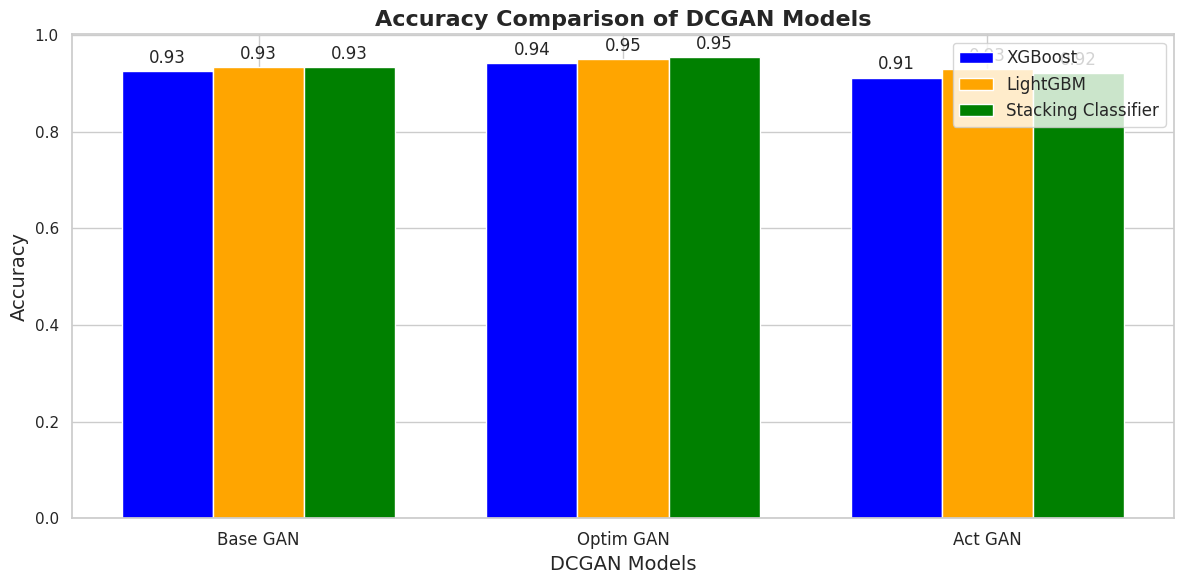

In [38]:
labels = ['Base GAN', 'Optim GAN', 'Act GAN']
xgb_accuracies = [base_xgb_metrics["Accuracy"], optim_xgb_metrics["Accuracy"], 
                  act_xgb_metrics["Accuracy"]]

lgb_accuracies = [base_lgb_metrics["Accuracy"], optim_lgb_metrics["Accuracy"], 
                  act_lgb_metrics["Accuracy"]]

sclf_accuracies = [base_sclf_metrics["Accuracy"], optim_sclf_metrics["Accuracy"], 
                  act_sclf_metrics["Accuracy"]]
x = np.arange(len(labels))  
width = 0.25  

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, xgb_accuracies, width, label='XGBoost', color='blue')
rects2 = ax.bar(x, lgb_accuracies, width, label='LightGBM', color='orange')
rects3 = ax.bar(x + width, sclf_accuracies, width, label='Stacking Classifier', color='green')

ax.set_xlabel('DCGAN Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Accuracy Comparison of DCGAN Models', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.tight_layout()
plt.savefig("combined_dcgan_classifier_accuracies.png", dpi=300, bbox_inches='tight')  
plt.show()

In [39]:
def convert_to_dtest(X_test, y_test):
    return xgb.DMatrix(X_test, label=y_test)


def plot_roc_curve(models, model_names, features, labels, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for i, model in enumerate(models):
        X_train, X_test, y_train, y_test = train_test_split(
            features[i], labels[i], test_size=0.2, random_state=42
        )
        
        if "XGBoost" in model_names[i]:
            dtest = convert_to_dtest(X_test, y_test)
            y_pred_prob = model.predict(dtest)
        else:
            y_pred_prob = model.predict(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_names[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Comparative ROC Curve', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.savefig("combined_dcgan_classifier_roc_curve.png", dpi=300, bbox_inches='tight')  
    plt.show()

def plot_precision_recall_curve(models, model_names, features, labels, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for i, model in enumerate(models):
        X_train, X_test, y_train, y_test = train_test_split(
            features[i], labels[i], test_size=0.2, random_state=42
        )
        
        if "XGBoost" in model_names[i]:
            dtest = convert_to_dtest(X_test, y_test)
            y_pred_prob = model.predict(dtest)
        else:
            y_pred_prob = model.predict(X_test)

        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        plt.plot(recall, precision, label=f'{model_names[i]}')

    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Comparative Precision-Recall Curve', fontsize=16, fontweight='bold')
    plt.legend(loc="best", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.savefig("combined_dcgan_classifier_pcr.png", dpi=300, bbox_inches='tight')  
    plt.show()


In [40]:
models = [
    base_xgb_model, base_lgb_model, base_sclf,
    optim_xgb_model, optim_lgb_model, optim_sclf,
    act_xgb_model, act_lgb_model, act_sclf,
]

model_names = [
    "Base XGBoost", "Base LightGBM", "Base Stacking Classifier",
    "Optim XGBoost", "Optim LightGBM", "Optim Stacking Classifier",
    "Act XGBoost", "Act LightGBM", "Act Stacking Classifier",
]

features = [
    base_features, base_features, base_features,
    optim_features, optim_features, optim_features, 
    act_features, act_features, act_features,
]

labels = [
    base_labels, base_labels, base_labels,
    optim_labels, optim_labels, optim_labels,
    act_labels, act_labels, act_labels,
]

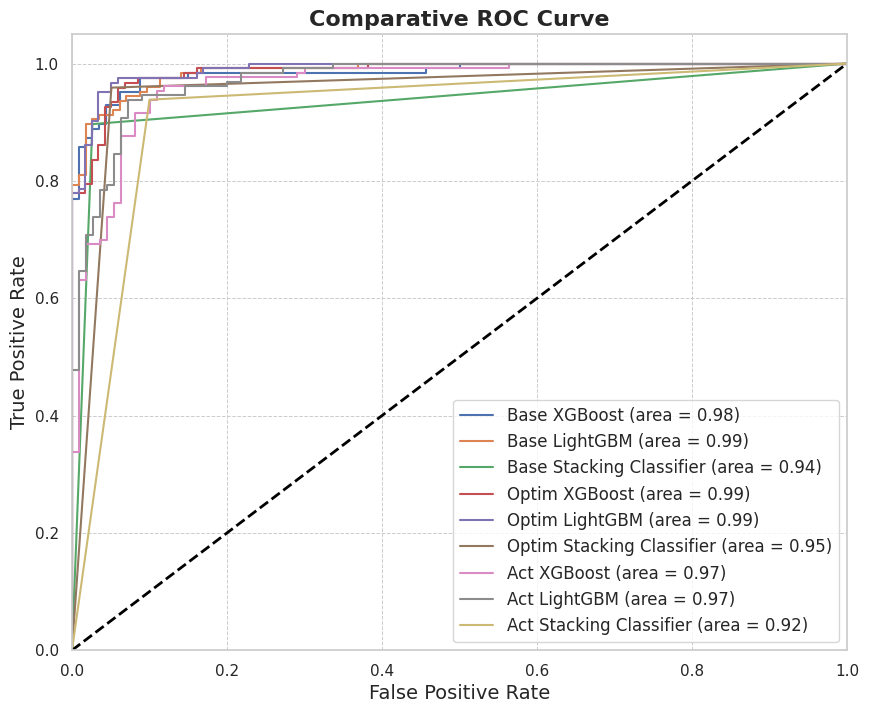

In [41]:
plot_roc_curve(models, model_names, features, labels)

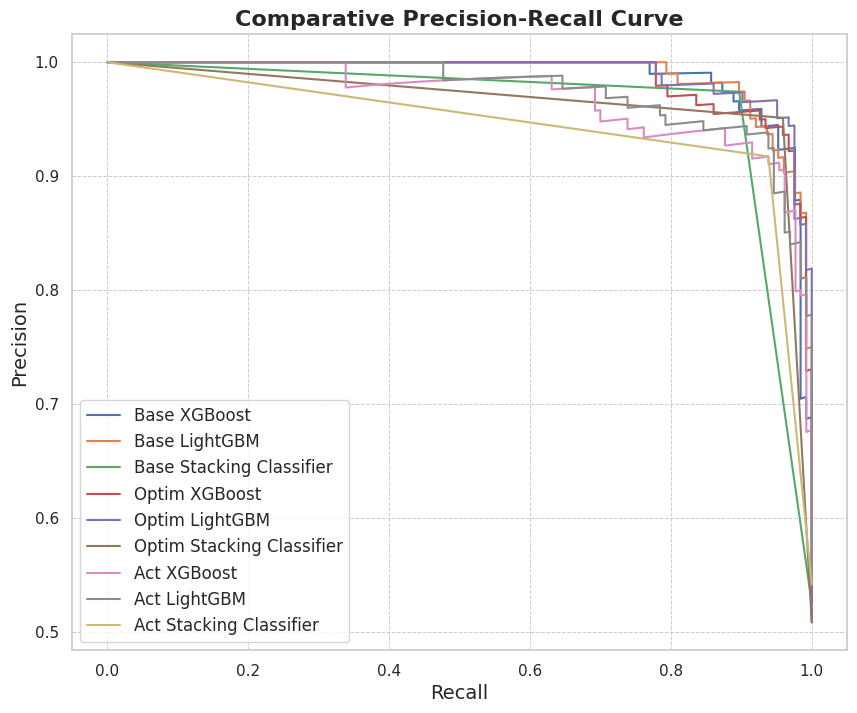

In [42]:
plot_precision_recall_curve(models, model_names, features, labels)

In [27]:
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(optim_features)

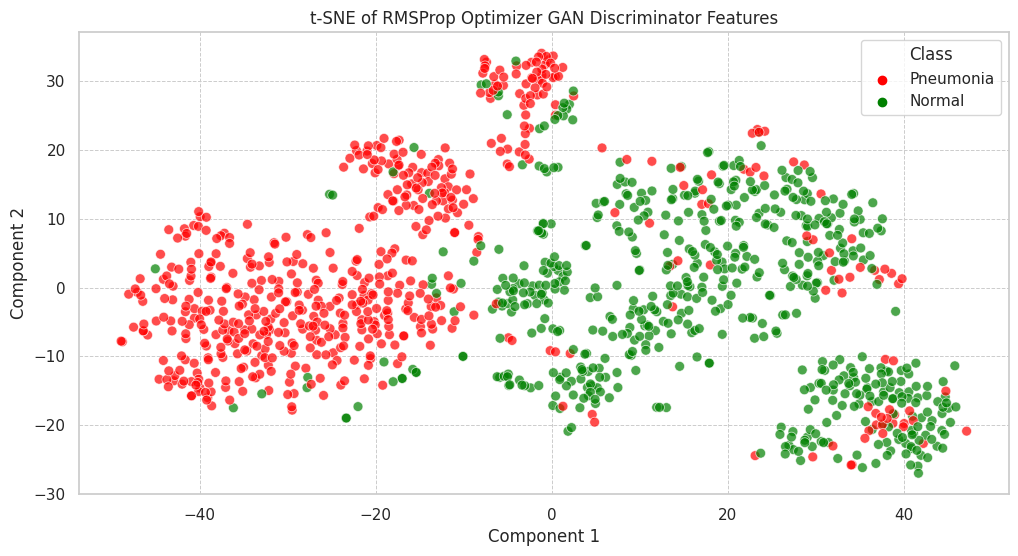

In [28]:
df_tsne = pd.DataFrame({
    'Component 1': features_tsne[:, 0],
    'Component 2': features_tsne[:, 1],
    'Label': np.where(optim_labels == 0, 'Normal', 'Pneumonia') 
})

custom_palette = {'Normal': 'green', 'Pneumonia': 'red'}

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_tsne, x='Component 1', y='Component 2', hue='Label', palette=custom_palette, s=50, alpha=0.7)

plt.title('t-SNE of RMSProp Optimizer GAN Discriminator Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, linestyle='--', linewidth=0.7)

plt.legend(title='Class')
plt.savefig("tsne_features.png", dpi=300, bbox_inches='tight')  
plt.show()

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
features_tsne_3d = tsne.fit_transform(optim_features)

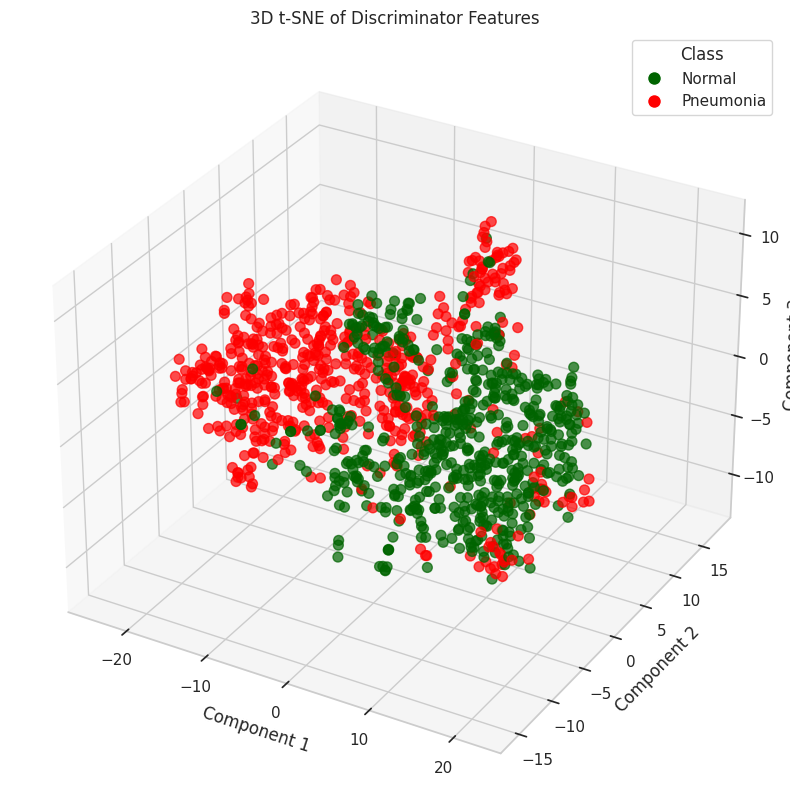

In [30]:
custom_palette = {'Normal': 'darkgreen', 'Pneumonia': 'red'}

df_tsne_3d = pd.DataFrame({
    'Component 1': features_tsne_3d[:, 0],
    'Component 2': features_tsne_3d[:, 1],
    'Component 3': features_tsne_3d[:, 2],
    'Label': np.where(optim_labels == 0, 'Normal', 'Pneumonia')  
})
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_tsne_3d['Component 1'], df_tsne_3d['Component 2'], df_tsne_3d['Component 3'],
                     c=df_tsne_3d['Label'].map(custom_palette), s=50, alpha=0.7)

ax.set_title('3D t-SNE of Discriminator Features')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[label], markersize=10) for label in custom_palette]
ax.legend(handles, custom_palette.keys(), title='Class')
plt.savefig("tsne_features_3d.png", dpi=300, bbox_inches='tight')  
plt.show()

In [33]:
color_map = {'Normal': 'darkgreen', 'Pneumonia': 'red'}

fig_tsne = px.scatter_3d(df_tsne_3d, x='Component 1', y='Component 2', z='Component 3', 
                         color='Label', color_discrete_map=color_map,
                         title='3D t-SNE of Discriminator Features',
                         labels={'Component 1': 'Component 1', 'Component 2': 'Component 2', 'Component 3': 'Component 3'})

fig_tsne.update_traces(marker=dict(size=5))
fig_tsne.update_layout(scene=dict(
    xaxis_title='Component 1',
    yaxis_title='Component 2',
    zaxis_title='Component 3'
))

fig_tsne.show()